In [1]:
# let's see what is in labels file

import pandas as pd
from cv2 import cv2
import matplotlib.pyplot as plt  # plot
import os
from os.path import join

path = ('/kaggle/input/affectnet-training-data/')
file = (path + 'labels.csv')
df = pd.read_csv(file)
df.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


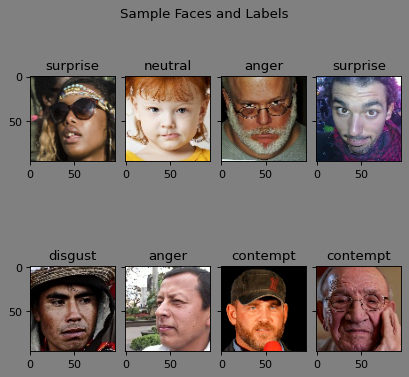

In [2]:
# display random images

import random

fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, num=None, 
                        figsize=(5, 5), dpi=80, facecolor='gray', edgecolor='k')
fig.suptitle("Sample Faces and Labels")
axs = axs.flatten()

for i in range(8):
    idx = random.randint(0, len(df)-1)  # randomly select an index
    img_path = path + df['pth'][idx]
    img = cv2.imread(img_path)  # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
    axs[i].imshow(img)
    axs[i].set_title(df['label'][idx])


In [3]:
# how many emotions categories

import os

INPUT_PATH = "/kaggle/input/affectnet-training-data/"
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (96, 96)

print(EMOTIONS)

['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']


In [4]:
# define functions to pre-process and load images into arrays

import cv2
import numpy as np
from keras.utils import to_categorical
import os

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            #img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))
    return X, y

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Load the images
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape
#input_shape = (96,96,1) 

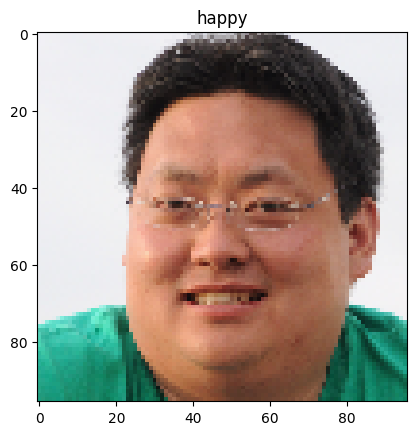

In [6]:
import matplotlib.pyplot as plt

# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.show()


In [7]:
# Train test split pre-processed data

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# # create a stratified train-test split
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
# for train_index, test_index in split.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]



In [8]:
from keras.models import Sequential
from keras.layers import Conv2D,LSTM,Bidirectional,Reshape, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(16, (3,3), activation="relu", strides=(1,1), padding='valid', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), activation="relu", strides=(1,1), padding='valid', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation="relu", strides=(1,1), padding='valid'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation="relu", strides=(1,1), padding='valid'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())

model.add(Reshape((-1,128)))
model.add(Bidirectional(LSTM(128)))
model.add(Reshape((-1,64)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer = Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 32)       1

/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = model.fit(X_train, y_train, batch_size=16,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                                 patience=3, min_lr=0.0001)],
                    verbose=1)

Epoch 1/30


2023-05-05 12:56:48.728119: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1453/1453 [==============================] - 37s 17ms/step - loss: 1.8019 - accuracy: 0.4037 - val_loss: 1.6078 - val_accuracy: 0.4476 - lr: 0.0010
Epoch 2/30
1453/1453 [==============================] - 24s 17ms/step - loss: 1.5378 - accuracy: 0.4968 - val_loss: 1.4451 - val_accuracy: 0.5152 - lr: 0.0010
Epoch 3/30
1453/1453 [==============================] - 23s 16ms/step - loss: 1.4785 - accuracy: 0.5248 - val_loss: 1.4117 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 4/30
1453/1453 [==============================] - 24s 17ms/step - loss: 1.4251 - accuracy: 0.5407 - val_loss: 1.3641 - val_accuracy: 0.5734 - lr: 0.0010
Epoch 5/30
1453/1453 [==============================] - 24s 17ms/step - loss: 1.3779 - accuracy: 0.5584 - val_loss: 1.2599 - val_accuracy: 0.5736 - lr: 0.0010
Epoch 6/30
1453/1453 [==============================] - 24s 16ms/step - loss: 1.3393 - accuracy: 0.5640 - val_loss: 1.2447 - val_accuracy: 0.5910 - lr: 0.0010
Epoch 7/30
1453/1453 [==============================] - 2

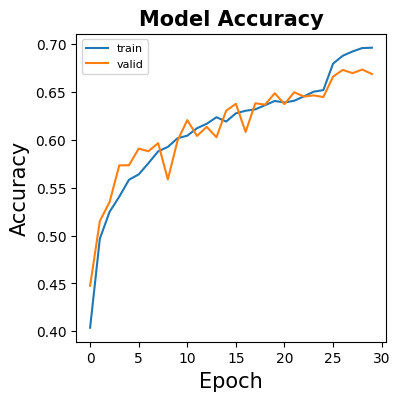

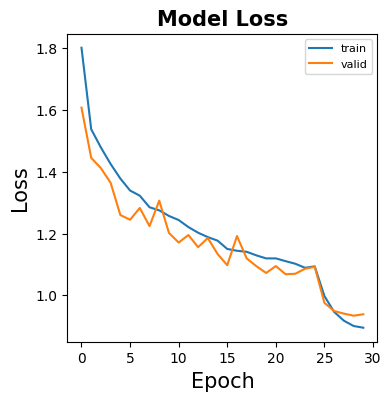

In [13]:
# print(history.history.keys())
#  "Accuracy"
fig = plt.figure(0, (4,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 15, fontweight=800)
plt.ylabel('Accuracy', fontsize = 15, fontweight=500)
plt.xlabel('Epoch', fontsize = 15, fontweight=500)
plt.legend(['train', 'valid'], loc='upper left',fontsize=8)
plt.show()
fig = plt.figure(0, (4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 15, fontweight=800)
plt.ylabel('Loss', fontsize = 15, fontweight=500)
plt.xlabel('Epoch', fontsize = 15, fontweight=500)
# plt.xlabel('E  h', fontsize = 15, fontweight=700)
plt.legend(['train', 'valid'], loc='upper right',fontsize=8)
plt.show()

In [11]:
from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

182/182 [==============================] - 3s 6ms/step


              precision    recall  f1-score   support

           0       0.54      0.69      0.61       815
           1       0.70      0.32      0.44       660
           2       0.87      0.89      0.88       982
           3       0.47      0.56      0.52       582
           4       0.59      0.34      0.43       517
           5       0.61      0.72      0.66       578
           6       0.92      0.91      0.92       988
           7       0.52      0.61      0.56       687

    accuracy                           0.67      5809
   macro avg       0.65      0.63      0.63      5809
weighted avg       0.68      0.67      0.66      5809



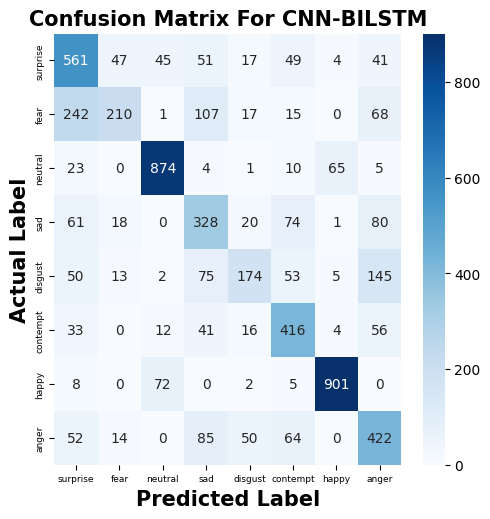

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test_int, y_pred_int))
import seaborn as sn
import tensorflow as tf
cm = tf.math.confusion_matrix(labels = y_test_int, predictions = y_pred_int)

plt.figure(figsize = (5.6,5.6))
ax = plt.axes()
sn.heatmap(cm,cmap="Blues", annot = True, fmt = 'd')
ax.xaxis.set_ticklabels([ "surprise","fear","neutral","sad","disgust","contempt","happy","anger"], fontsize=6.5);
ax.yaxis.set_ticklabels([ "surprise","fear","neutral","sad","disgust","contempt","happy","anger"], fontsize=6.5);
# ax.yaxis.set_ticklabels([  "Happy", "Surprise", "Anger", "Sadness", "Fear"],  fontsize=9);


plt.title('Confusion Matrix For CNN-BILSTM', fontsize = 15, fontweight=1000)
plt.xlabel('Predicted Label', fontsize = 15, fontweight=1000)
plt.ylabel('Actual Label', fontsize = 15, fontweight=1000)



plt.savefig("Confusion Matrix")